# Water Pump Functionality Prediction - Portfolio Project

## Project Overview
This project explores the use of machine learning to predict the functionality status of water pumps in rural areas. The dataset includes 
features such as water source, pump type, distance to town, population served, and funding organization.

**Goal**: Build a predictive model to determine whether a water pump is functional or non-functional.


In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## Set and Verify Working Directory

Before loading the dataset, we confirm the current working directory and change it to the location where the cleaned data file is stored.


In [4]:
# Set and Verify Working Directory

# PYthon library
import os

print("Current working directory:", os.getcwd())

os.chdir(r"C:\Users\jgpet\OneDrive\Desktop\Gradiate school\2025\DSCI 5240\Final Project")
print("New working directory:", os.getcwd())

Current working directory: C:\Users\jgpet\DSCI5240\Final Project
New working directory: C:\Users\jgpet\OneDrive\Desktop\Gradiate school\2025\DSCI 5240\Final Project


## Load Dataset
Set the working directory and load the cleaned dataset into memory.

In [6]:
# Load Dataset
Final_project = pd.read_csv("Final_project_clean.csv", header=0)
pd.set_option("display.max_columns", None)

## Handle Outliers

Use the IQR method to detect and cap outliers in numerical features:
- Distance to Nearest Town
- Population Served
- Water Pump Age

In [8]:
# Outlier Detection & Capping
num_cols = ['Distance to Nearest Town', 'Population Served', 'Water Pump Age']

for col in num_cols:
    Q1 = Final_project[col].quantile(0.25)
    Q3 = Final_project[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    Final_project[col] = Final_project[col].clip(lower=lower_bound, upper=upper_bound)

# Clip distance values below 0 to 0
Final_project['Distance to Nearest Town'] = Final_project['Distance to Nearest Town'].clip(lower=0)


## 🔤 Encode Categorical Variables

- Binary encoding for Water Quality, Payment Type, and Functioning Status  
- One-hot encoding for Water Source Type, Funder, Pump Type

In [10]:
# Encode Categorical Variables
binary_map = {
    'Water Quality': {'Clean': 0, 'Contaminated': 1},
    'Payment Type': {'Free': 0, 'Pay per use': 1},
    'Functioning Status': {'Not Functioning': 0, 'Functioning': 1}
}
df_encoded = Final_project.replace(binary_map)
categorical_cols = ['Water Source Type', 'Funder', 'Pump Type']
df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, drop_first=True)
df_encoded = df_encoded.astype(int)

C:\Users\jgpet\AppData\Local\Temp\ipykernel_27700\130284717.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_encoded = Final_project.replace(binary_map)


## 🧮 Variance Inflation Factor (VIF)

Detect multicollinearity and remove features with VIF > 10 to improve model interpretability.

In [12]:
# Define X and y
y = df_encoded['Functioning Status']
X = df_encoded.drop(columns='Functioning Status')

# VIF for Feature Selection
X_vif = X.astype(float)
vif_data = pd.DataFrame()
vif_data['Feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# Drop high VIF features
high_vif_features = ['Installation Year', 'Population Served']
X_reduced = X.drop(columns=high_vif_features)


## 📏 Feature Scaling

Standardize numerical features to ensure they contribute equally to the model.

In [14]:
# Scaling

scaler = StandardScaler()
numeric_cols = ['Distance to Nearest Town', 'Water Pump Age']
X_scaled = X_reduced.copy()
X_scaled[numeric_cols] = scaler.fit_transform(X_scaled[numeric_cols])

## 🤖 Neural Network Model (Keras)

Train a neural network to classify water pumps as functioning or not.

In [16]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=4)

In [17]:
# Build Neural Network
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(12, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

C:\Users\jgpet\anaconda31\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train Model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5993 - loss: 0.6793 - val_accuracy: 0.6529 - val_loss: 0.6523
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6135 - loss: 0.6658 - val_accuracy: 0.6529 - val_loss: 0.6388
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6295 - loss: 0.6504 - val_accuracy: 0.6657 - val_loss: 0.6242
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6377 - loss: 0.6417 - val_accuracy: 0.6657 - val_loss: 0.6134
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6579 - loss: 0.6326 - val_accuracy: 0.6886 - val_loss: 0.6032
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6732 - loss: 0.6182 - val_accuracy: 0.6957 - val_loss: 0.5947
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6771 - loss: 0.6103 - val_accuracy: 0.6986 - val_loss: 0.5933
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6683 - loss: 0.6196 - val_accuracy: 0.6871 - val_loss

## 📈 Model Evaluation

Display classification report and confusion matrix to evaluate performance.

In [20]:
# Evaluate Model
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.83      0.80       936
           1       0.67      0.58      0.62       564

    accuracy                           0.73      1500
   macro avg       0.72      0.70      0.71      1500
weighted avg       0.73      0.73      0.73      1500


Confusion Matrix:
 [[776 160]
 [239 325]]


## 📊 Training History

Visualize accuracy and loss across epochs for both training and validation sets.

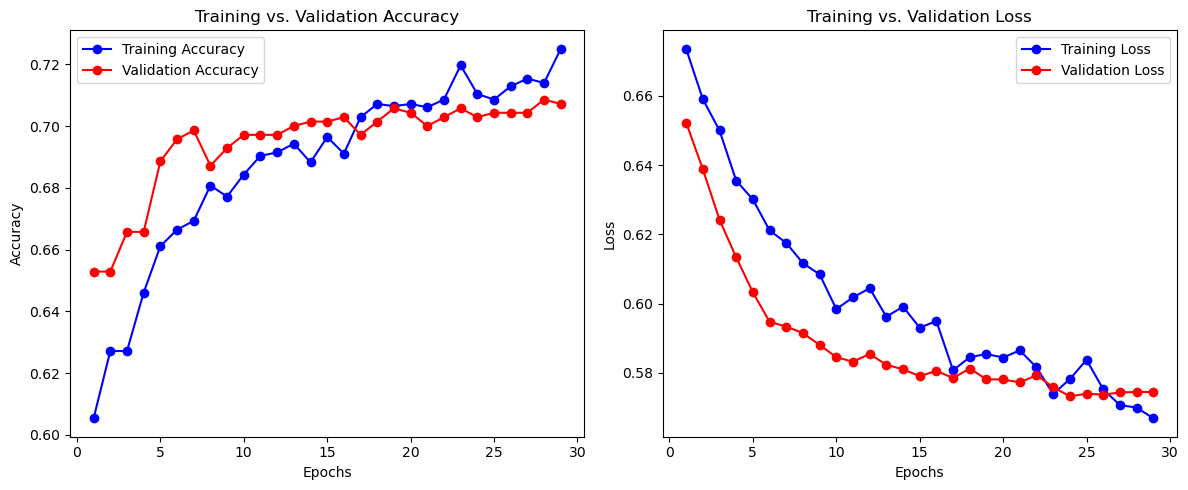

In [22]:
# Plot Accuracy and Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [23]:
# Final Metrics
final_epoch = len(acc) - 1
print("\nFinal Epoch Metrics:")
print(f"Training Accuracy     : {acc[final_epoch]:.4f}")
print(f"Validation Accuracy   : {val_acc[final_epoch]:.4f}")
print(f"Training Loss         : {loss[final_epoch]:.4f}")
print(f"Validation Loss       : {val_loss[final_epoch]:.4f}")


Final Epoch Metrics:
Training Accuracy     : 0.7250
Validation Accuracy   : 0.7071
Training Loss         : 0.5669
Validation Loss       : 0.5745
